"""
Script for containing a full convolutional neural network (FCN), see 
arxiv:1611.06455, to classify Monte Carlo (MC)
timelines

By Bernhard Irsigler
"""

In [2]:
from __future__ import print_function
 
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras.regularizers import l1, l2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 20,
})

In [4]:
class FCN_CAM:
    def loadData(self, num_spins, num_clauses, num_mc_runs, start_temperature, binning,
            number = 1, as_channels = True):
        self.num_mc_runs = num_mc_runs
        # Load and prepare data, filename is standard, path has to be modified
        file_name = f'ec3_stim_anneal_spins{num_spins}_clauses{num_clauses}' + \
            f'_runs{num_mc_runs}_temp{start_temperature}_{number}'
        path = f'../ML_MC/{file_name}.npz'
        data = np.load(path)
        
        # Assign features and labels
        ftrs = data['res_mc_timelines']
        lbls = data['res_fidelity'][:, -1]
        
        # Perform min max normalization.
        ftrs = ftrs - ftrs.min()
        ftrs /= ftrs.max() - ftrs.min()
        
        # Whether instances specific MC repetitions should be treated as channels or as 
        # separate data.
        if not as_channels:
            lbls = lbls.repeat(10, axis = 0)
            ftrs = ftrs.transpose((0, 2, 1)).reshape((-1, num_mc_runs, 1))
            
        # Determine the binning of the fidelities, binning is either a number or a list.
        # The small added and subtracted values make sure the data is completely contain 
        # in the binning.
        if type(binning) == int:
            binning = np.linspace(lbls.min() - 1e-3, lbls.max() + 1e-3, binning + 1)
        elif type(binning) in [list, numpy.ndarray]:
            if lbls.min() < binning[0] or lbls.max() > binning[-1]:
                print('Chosen binning data excludes data.')
        else:
            print('Chosen binning has wrong type.')
        
        self.binning = binning
            
        # Set classes for fidelity.
        self.num_classes = binning.shape[0] - 1
        
        # binning of labels
        lbls = np.digitize(lbls, binning)
        
        # Train/test split
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            ftrs, lbls, test_size = .2)

        self.y_train = (self.y_train - self.y_train.min()) \
            / (self.y_train.max() - self.y_train.min()) \
            * (self.num_classes - 1)
        self.y_test = (self.y_test - self.y_test.min()) \
            / (self.y_test.max() - self.y_test.min()) \
            * (self.num_classes - 1)

        self.Y_train = keras.utils.to_categorical(self.y_train, self.num_classes)
        self.Y_test = keras.utils.to_categorical(self.y_test, self.num_classes)

        x_train_mean = self.x_train.mean()
        x_train_std = self.x_train.std()
        self.x_train = (self.x_train - x_train_mean)/(x_train_std)

        self.x_test = (self.x_test - x_train_mean)/(x_train_std)
        
    def buildModel(self, num_conv, l2_reg, learning_rate):
        # Building the FCN, the layers should not be changed as the CAM calculation will
        # will depend on this structure lateron.
        x = keras.layers.Input(self.x_train.shape[1:])
        conv1 = keras.layers.Conv1D(num_conv, 8, padding = 'same', 
            kernel_regularizer = l2(l2_reg))(x)
        conv1 = keras.layers.BatchNormalization()(conv1)
        conv1 = keras.layers.Activation('relu')(conv1)

        conv2 = keras.layers.Conv1D(2 * num_conv, 5, padding = 'same', 
            kernel_regularizer = l2(l2_reg))(conv1)
        conv2 = keras.layers.BatchNormalization()(conv2)
        conv2 = keras.layers.Activation('relu')(conv2)

        conv3 = keras.layers.Conv1D(num_conv, 3, padding = 'same', 
            kernel_regularizer = l2(l2_reg))(conv2)
        conv3 = keras.layers.BatchNormalization()(conv3)
        conv3 = keras.layers.Activation('relu')(conv3)

        full = keras.layers.GlobalAveragePooling1D()(conv3)
        out = keras.layers.Dense(self.num_classes, activation = 'softmax')(full)

        self.model = keras.models.Model(inputs = x, outputs = out)

        optimizer = keras.optimizers.Adam(learning_rate)
        self.model.compile(loss = 'categorical_crossentropy', optimizer = optimizer,
            metrics = ['accuracy'])
        
    def trainModel(self, num_epochs, batch_size = 256):
        # Train the model, the learning rate reduction is not used
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,
            patience = 50, min_lr = 0.0001) 
        self.model.fit(self.x_train, self.Y_train, batch_size = batch_size, 
            epochs = num_epochs, verbose = 0, validation_split = .2,
            callbacks = [reduce_lr])
        
    def plotTrainingLoss(self):
        plt.semilogx(self.model.history.history['loss'], label = 'loss')
        plt.semilogx(self.model.history.history['val_loss'], label = 'val. loss')
        plt.legend()
        plt.xlabel('epochs')
        
    def plotPrediction(self):
        fig, axs = plt.subplots(ncols = 2, figsize=(10, 5), sharey = True)
        axs[0].hist2d(self.y_train, 
            np.argmax(self.model.predict(self.x_train), axis = 1), 
            bins = self.num_classes);
        axs[1].hist2d(self.y_test,
            np.argmax(self.model.predict(self.x_test), axis = 1), 
            bins = self.num_classes);

        axs[0].set_ylabel('predicted fidelity')
        axs[0].set_xlabel('true fidelity')
        axs[1].set_xlabel('true fidelity')

        axs[0].set_title('train set')
        axs[1].set_title('test set')
        
    def computeCAM(self):
        # Compute the class activation map on the test data
        get_last_conv = keras.backend.function([self.model.layers[0].input], 
            [self.model.layers[-3].output])
        last_conv = get_last_conv(self.x_test)[0]

        get_softmax = keras.backend.function([self.model.layers[0].input], 
            [self.model.layers[-1].output])
        softmax = get_softmax((self.x_test))[0]
        softmax_weight = self.model.get_weights()[-2]
        self.CAM = np.dot(last_conv, softmax_weight)
        
    def plotNormalizedCAM(self):
        for i in range(len(self.binning) - 1):
            temp = np.average(self.CAM[..., i], axis = 0)
            plt.plot(np.arange(self.num_mc_runs),
                (temp - temp.min())/ (temp.max() - temp.min()), 
                label = 'fidelity ' \
                     + f'$\in [{self.binning[i].round(2)},{self.binning[i+1].round(2)}]$'
            )
            plt.legend(bbox_to_anchor = (1, 1))
            plt.title('Normalized CAM')
            plt.xlabel('$t$')
            plt.ylabel(r'$\mathrm{CAM}(t)$')
            
    def plotMC_CAM(self):
        offset = 2.5
        for i in range(len(self.binning) - 1):
            temp = np.average(self.CAM[..., i], axis = 0)

            plt.fill_between(np.arange(self.num_mc_runs), 
                offset * i + np.average(self.x_test[self.y_test == i], axis = (0, -1)) \
                    + np.std(self.x_test[self.y_test == i], axis = (0, -1)),
                offset * i + np.average(self.x_test[self.y_test == i], axis = (0, -1)) \
                    - np.std(self.x_test[self.y_test == i], axis = (0, -1)),
                alpha = .5,label = 'fidelity ' \
                     + f'$\in [{self.binning[i].round(2)},{self.binning[i+1].round(2)}]$'
            )
            plt.scatter(np.arange(self.num_mc_runs), 
                offset * i + np.average(self.x_test[self.y_test == i], axis = (0, -1)), 
                c = (temp - temp.min())/ (temp.max() - temp.min()),
                cmap = 'Greys')
        plt.colorbar()
        plt.legend(bbox_to_anchor = (1.2, 1))
        plt.ylabel('MC timelines with offset')
        plt.xlabel('$t$')
        plt.title('CAM as colormap')

In [5]:
fcn = FCN_CAM()

In [6]:
# Example for 7 spins, 5 clauses, 100 MC timesteps, 10 repetitions with a binning of 5
fcn.loadData(7, 5, 100, 10, 5)

In [7]:
fcn.buildModel(32, .0001, .0001)

In [8]:
fcn.trainModel(200)

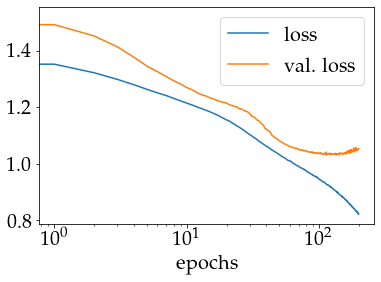

In [9]:
fcn.plotTrainingLoss()

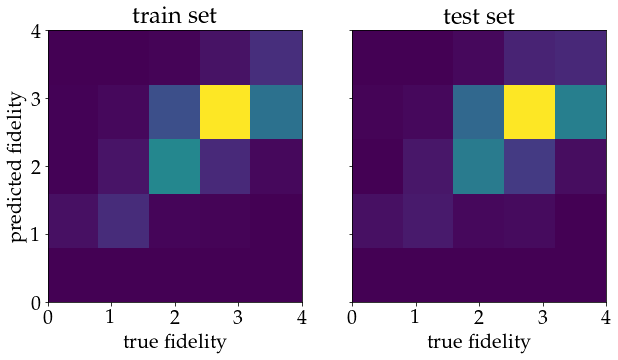

In [10]:
fcn.plotPrediction()

In [11]:
fcn.computeCAM()

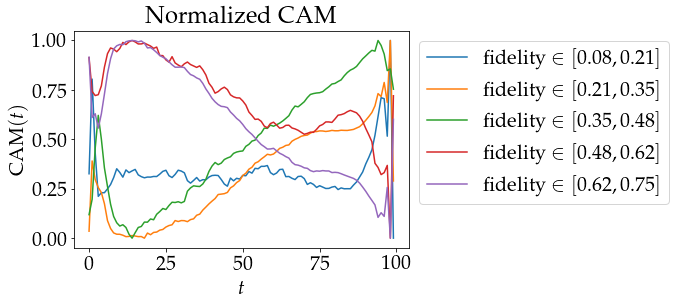

In [12]:
fcn.plotNormalizedCAM()

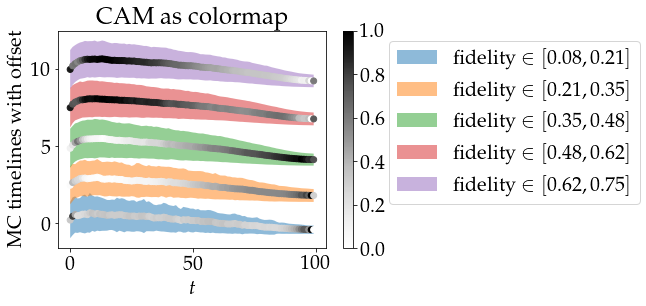

In [13]:
fcn.plotMC_CAM()